# FBB_Reproducibility GOATOOLS: A Python library for Gene Ontology analyses

### Part #1.1: Подготовка датасета: DAVID 6.7, DAVID 6.8

Для воспроизведения результатов статьи "GOATOOLS: A Python library for Gene Ontology analyses" (https://www.nature.com/articles/s41598-018-28948-z) были использованы данные из Supplementary Table 1 в статье "Conserved epigenomic signals in mice and humans reveal immune basis of Alzheimer’s disease" (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4530583/).

Создавался файл с Ensembl ID, который в последствии подавался на вход различным тулам.

In [1]:
import pandas as pd
df = pd.read_excel('nature14252-s1.xlsx', sheet_name='masterInfo.4.3.7.txt', header=1)
cols = [4,9]
new_df = df.drop(df.columns[cols], axis=1)
new_df['Ensembl ID'].to_csv('Ensembl_ID.txt', sep='\t', index=False, header=False)

Код ниже выводит количество генов в определённом кластере. 

In [2]:
tr_in = (new_df.Cluster.values == 'Transient Increase').sum()
con_in = (new_df.Cluster.values == 'Consistent Increase').sum()
late_in = (new_df.Cluster.values == 'Late Increase').sum()
tr_de = (new_df.Cluster.values == 'Transient Decrease').sum()
con_de = (new_df.Cluster.values == 'Consistent Decrease').sum()
late_de = (new_df.Cluster.values == 'Late Decrease').sum()
none = (new_df.Cluster.values == 'None').sum()
all_genes = tr_in + con_in + late_in + con_de + late_de + tr_de + none
print('Transient Increase = ' + str(tr_in))
print('Consistent Increase = ' + str(con_in))
print('Late Increase = ' + str(late_in))
print('Transient Decrease = ' + str(tr_de))
print('Consistent Decrease = ' + str(con_de))
print('Late Decrease = ' + str(late_de))
print('Total = ' + str(all_genes))

Transient Increase = 624
Consistent Increase = 794
Late Increase = 1397
Transient Decrease = 142
Consistent Decrease = 1029
Late Decrease = 1139
Total = 13836


К сожалению, из-за большого списка генов (13836) использовать APi не рекомендовалось в DAVID 6.7 и 6.8, поэтому данные были поданы на вход вручную, а результат обработан далее в этом работе.

In [3]:
df68 = pd.read_csv('6.8_DIRECT.txt', sep="\t")
df67 = pd.read_csv('6.7_ALL.txt', sep="\t")
df68['PValue'].to_csv('6.8_PValue.txt', sep='\t', index=False, header=False)
df67['PValue'].to_csv('6.7_PValue.txt', sep='\t', index=False, header=False)

### Part #1.2: Подготовка датасета: GOATools

Подготовку GOstats мы не делали, так как она осуществляется с помощью R, а у нас лапки

In [4]:
from goatools.base import download_go_basic_obo
import os
if not os.path.exists('go-basic.obo'):
    # Get http://geneontology.org/ontology/go-basic.obo
    download_go_basic_obo()


In [5]:
from goatools.base import download_ncbi_associations  # Download Associations
fin_gene2go = download_ncbi_associations() # занимает много времени: ~20mins


  EXISTS: gene2go


In [6]:
from goatools.obo_parser import GODag
obodag = GODag("go-basic.obo")  # Load Ontologies


go-basic.obo: fmt(1.2) rel(2019-05-09) 47,407 GO Terms


In [7]:
from goatools.anno.genetogo_reader import Gene2GoReader

# Read NCBI's gene2go. Store annotations in a list of namedtuples
objanno = Gene2GoReader(fin_gene2go, taxids=[10090])

# Get namespace2association where:
#    namespace is:
#        BP: biological_process
#        MF: molecular_function
#        CC: cellular_component
#    assocation is a dict:
#        key: NCBI GeneID
#        value: A set of GO IDs associated with that gene
ns2assoc = objanno.get_ns2assc()

for nspc, id2gos in ns2assoc.items():
    print("{NS} {N:,} annotated mouse genes".format(NS=nspc, N=len(id2gos)))
    for protein_id, go_ids in sorted(id2gos.items())[:3]:
        print("{NS} {PROT:7} : {GOs}".format(
            NS=nspc,
            PROT=protein_id,
            GOs=' '.join(sorted(go_ids))))


HMS:0:00:07.576999 363,913 annotations READ: gene2go 
1 taxids stored: 10090
BP 17,738 annotated mouse genes
BP   11287 : GO:0007566 GO:0010466
BP   11298 : GO:0006474 GO:0007623 GO:0009416 GO:0009648 GO:0010043 GO:0014070 GO:0030187 GO:0032868 GO:0034695 GO:0046688 GO:0048511 GO:0071320
BP   11302 : GO:0006468 GO:0006915 GO:0007420 GO:0016310 GO:0030517 GO:0032482 GO:0038083 GO:0046777 GO:0051402
MF 16,802 annotated mouse genes
MF   11287 : GO:0002020 GO:0004866 GO:0004867 GO:0030414 GO:0044877 GO:0048403 GO:0048406
MF   11298 : GO:0004059 GO:0004060 GO:0016740 GO:0016746 GO:0071889
MF   11302 : GO:0000166 GO:0004672 GO:0004674 GO:0004713 GO:0005515 GO:0005524 GO:0016301 GO:0016740
CC 18,929 annotated mouse genes
CC   11287 : GO:0005576 GO:0005615 GO:0062023
CC   11298 : GO:0005737 GO:0005829 GO:0048471
CC   11302 : GO:0005737 GO:0005783 GO:0016020 GO:0016021 GO:0042995 GO:0044295 GO:0048471 GO:0055037


In [8]:
from goatools.test_data.genes_NCBI_10090_ProteinCoding import GENEID2NT as GeneID2nt_mus
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

goeaobj = GOEnrichmentStudyNS(
    GeneID2nt_mus.keys(),  # List of mouse protein-coding genes
    ns2assoc,  # geneid/GO associations
    obodag,  # Ontologies
    propagate_counts=False,
    alpha=0.05,  # default significance cut-off
    methods=['fdr_bh'])  # defult multipletest correction method



Load BP Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 59% 16,748 of 28,212 population items found in association

Load CC Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 65% 18,278 of 28,212 population items found in association

Load MF Gene Ontology Analysis ...
fisher module not installed.  Falling back on scipy.stats.fisher_exact
 58% 16,418 of 28,212 population items found in association


In [9]:
geneid2symbol = {}
# Read data
if os.path.isfile("dataf.xlsx"):
    import xlrd
    book = xlrd.open_workbook("dataf.xlsx")
    pg = book.sheet_by_index(0)
    for r in range(pg.nrows):
        symbol, geneid, pval = [pg.cell_value(r, c) for c in range(pg.ncols)]
        if geneid:
            geneid2symbol[int(geneid)] = symbol
    print('{N} genes READ: {XLSX}'.format(N=len(geneid2symbol), XLSX="dataf.xlsx"))
else:
    raise RuntimeError('FILE NOT FOUND: {XLSX}'.format(XLSX="dataf.xlsx"))


13439 genes READ: dataf.xlsx


In [10]:
geneids_study = geneid2symbol.keys()
goea_results_all = goeaobj.run_study(geneids_study)
goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]


Run BP Gene Ontology Analysis: current study set of 13439 IDs ...
 86% 11,101 of 12,873 study items found in association
 96% 12,873 of 13,439 study items found in population(28212)
Calculating 12,192 uncorrected p-values using fisher_scipy_stats
  12,192 GO terms are associated with 16,748 of 28,212 population items
  10,981 GO terms are associated with 11,101 of 13,439 study items
  METHOD fdr_bh:
   1,835 GO terms found significant (< 0.05=alpha) (1808 enriched +  27 purified): statsmodels fdr_bh
  10,647 study items associated with significant GO IDs (enriched)
     451 study items associated with significant GO IDs (purified)

Run CC Gene Ontology Analysis: current study set of 13439 IDs ...
 92% 11,820 of 12,873 study items found in association
 96% 12,873 of 13,439 study items found in population(28212)
Calculating 1,725 uncorrected p-values using fisher_scipy_stats
   1,725 GO terms are associated with 18,278 of 28,212 population items
   1,640 GO terms are associated with 11,

In [11]:
# Для удосбтва пишем в xls, потому что в txt есть как \t так и пробелы. Неудобно читать в df
goeaobj.wr_xlsx("nbt3102.xlsx", goea_results_sig)
# Для скорости пишем в txt формат
# goeaobj.wr_txt("nbt3102.txt", goea_results_sig)

   3022 items WROTE: nbt3102.xlsx


### Part 2: Обработка датасета

In [12]:
from goatools import obo_parser as op
from goatools.base import download_go_basic_obo
import os
if not os.path.exists('go-basic.obo'):
    # Get http://geneontology.org/ontology/go-basic.obo
    download_go_basic_obo()
# Holds a GO Directed Acyclic Graph (DAG) as a dict. Дополнительная опция relationship для того, чтобы подтянуть relationships
# из 'go-basic.obo'. По дефолту отключён для оптимизации работы программы
go = op.GODag('go-basic.obo', optional_attrs=['relationship'])


go-basic.obo: fmt(1.2) rel(2019-05-09) 47,407 GO Terms; optional_attrs(relationship)


In [13]:
# Создаём .csv в формате 'GO id,all_lowers\n'
with open('descendants_quantity.csv', 'w') as output:
    ids = []
    for id in go:
        # Метод DAGTerm.get_all_lower() возвращает всех детей=потомков
        # (=поля 'relationshipis' + инвертированное 'is_a'
        to_write = id + ',' + str(len(go[id].get_all_lower())) + '\n'
        output.write(to_write)


In [14]:
import pandas as pd
goat_descendants = pd.read_csv(
    'descendants_quantity.csv',
    sep=',',
    header=None)
goat_descendants_dict = {}
# Делаем словарь в формате ключ-GO id, значение- число потомков
for row in goat_descendants.itertuples():
    goat_descendants_dict[row[1]] = row[2]


In [18]:
import numpy as np
from scipy.stats import pearsonr
# Необходим скачанный датасет. Число генов слишком большое для использования Api =>
# => необходимо вручную загрузить на сайт
# Названия датасетов могут отличаться :) так что нужно писать ваше


data = ["nbt3102.xlsx", "6.8_DIRECT.txt", "6.7_ALL.txt"]

def dcnt_assg_count():
    global data
    pearsonrs = []
    plots = {}
    for dataset in data:
        # Разделяем столбец Term по тильде '~' и добавляем новообразовавшиеся 2
        # столбца в конце датафрейма
        if dataset != "nbt3102.xlsx":
            df = pd.read_csv(dataset, sep='\t')
            df[['Id', 'Description']] = df.Term.str.split("~", expand=True)
        else:
            df = pd.read_excel("nbt3102.xlsx", header=0, sheet_name="Sheet1")
            df.rename(
                columns={
                    'GO': 'Id',
                    'study_items': 'Genes',
                    'p_fdr_bh': 'PValue'},
                inplace=True)
        # Отсев потенциально случайных находок. P-value <= 0.05
        df = df[df['PValue'] <= 0.05]
        ass_genes = {}
        # Для каждого GO id в goat_descendants находим соответствующее ему число ассоциированных белков и добавляет в словарь по ключу
        # этого GO id. Проверяем, находится ли вообще строка с таким GO id. Если нет - Nan.
        # В итоге получаем словарь, где ключи - все последовательно идущие GO
        # id в исходном go-basic.obo, а значения - число ассоц.генов
        for id in goat_descendants[0]:
            ass_genes[id] = []
            if len(df[df['Id'] == id]) != 0:
                a = df[df['Id'] == id].iloc[0]['Genes']
                b = len(str(a).split(","))
                ass_genes[id].append(b)
            else:
                ass_genes[id].append("NaN")
            '''if len(df[df['Id'] == id]) == 0:
                ass_genes_num = "NaN"
                ass_genes[id] = [ass_genes_num]
            else:
                if type(df[df['Id'] == id].iloc[0]['Genes'])'''                                    
        # Идём по ключам словаря с ассоц.генами, находим совпадение в df с
        # числом потомков, добавляет в список по ключу число потомков
        for key in ass_genes.keys():
            # ass_genes[key].append(goat_descendants[goat_descendants[0]==key].iloc[0][1]) медленно работает. Лучше со словарём
            # По ключу = GO id находим число потомков и добавляем в список
            ass_genes[key].append(goat_descendants_dict[key])
        key_list = []
        for k, v in ass_genes.items():
            if 'NaN' in v or 0 in v:
                continue
            else:
                if v[1] <= 1000 and v[0] <= 200:
                    key_list.append(k)
                else:
                    continue
        # pls noh8, это всё из-за прака по numpy'n'pandas и lambda functions. PS уже не нужно
        # david68_ass_genes = pd.DataFrame({'Id': sorted(list(ass_genes.keys())), 'Associatiated genes quantity':[ass_genes[key] for key in sorted(list(ass_genes.keys()))]})
        
        # делаем X-asis для графика. Потомки
        x = []
        for key in key_list:
            x.append(ass_genes[key][1])
        # делаем Y-asis для графика. Ассоц. гены
        y = []
        for key in key_list:
            y.append(ass_genes[key][0])
        plots[dataset] = []
        plots[dataset].append(x)
        plots[dataset].append(y)
        plots[dataset].append(pearsonr(x, y))
        print(dataset+' OK')
    return plots


In [19]:
plot_info = dcnt_assg_count()
plot_info.keys()

nbt3102.xlsx OK
6.8_DIRECT.txt OK
6.7_ALL.txt OK


dict_keys(['nbt3102.xlsx', '6.8_DIRECT.txt', '6.7_ALL.txt'])

# Part #3: визуализация

nbt3102.xlsx: Fig. 1 | pearsonr=0.23 | p=2.121612305249298e-26 | original: Fig. 5B1: 0.4, 1.2e-17


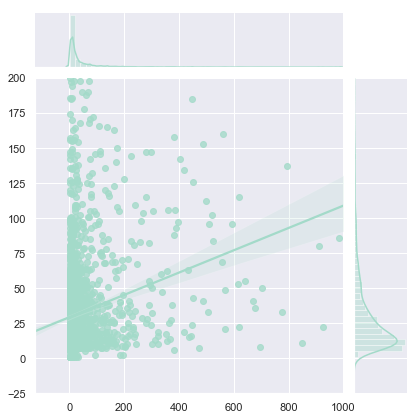

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")


def printer(n):
    a = data[n] + ': Fig. ' + str(n + 1) + ' | pearsonr=' + str(
        round(plot_info[data[n]][2][0], 2)) + ' | p=' + str(plot_info[data[n]][2][1])
    return a


print(printer(0) + " | original: Fig. 5B1: 0.4, 1.2e-17")
a = sns.jointplot(plot_info[data[0]][0],
                  plot_info[data[0]][1],
                  kind="reg",
                  ylim=(-25,
                        200),
                  xlim=(-125,
                        1000),
                  color='#A3DAC9')
a

6.7_ALL.txt: Fig. 3 | pearsonr=0.58 | p=9.224038179863841e-50 | original: Fig. 5B3: 0.88, 1.1e-158


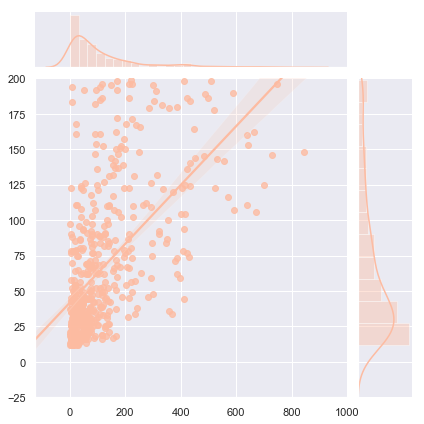

In [24]:
print(printer(2) + " | original: Fig. 5B3: 0.88, 1.1e-158")
c = sns.jointplot(plot_info[data[2]][0],
                  plot_info[data[2]][1],
                  kind="reg",
                  ylim=(-25,
                        200),
                  xlim=(-125,
                        1000),
                  color='#FDBBA1')
c

6.8_DIRECT.txt: Fig. 2 | pearsonr=0.36 | p=9.017009854135728e-21 | original: Fig. 5B3: 0.4, 2.4e-13


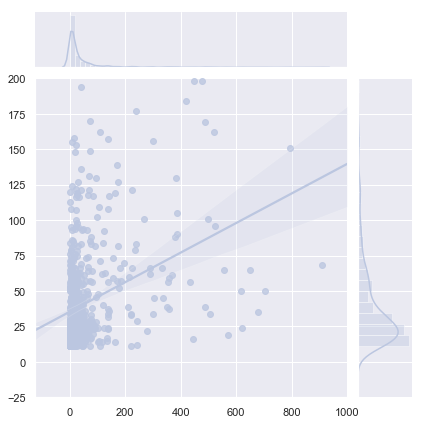

In [22]:
print(printer(1) + " | original: Fig. 5B3: 0.4, 2.4e-13")
b = sns.jointplot(plot_info[data[1]][0],
                  plot_info[data[1]][1],
                  kind="reg",
                  ylim=(-25,
                        200),
                  xlim=(-125,
                        1000),
                  color='#BBC6E0')
b

Text(0.5, 1.0, 'Fig. 5D: GOATools, DAVID v6.8, DAVID v6.8')

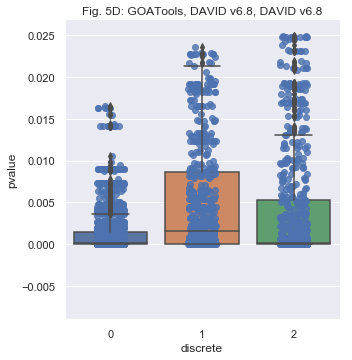

In [23]:
import pandas as pd
df = pd.read_excel('dataset.xlsx', sheet_name='Sheet2', header=0)
a = sns.lmplot(x='discrete', y='pvalue', data=df, x_jitter=.15, fit_reg=False)
a = sns.boxplot(x='discrete', y='pvalue', data=df)
a= plt.gca()
a.set_title("Fig. 5D: GOATools, DAVID v6.8, DAVID v6.8")